In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
pd.set_option('display.max_columns', None)    # Show all columns
pd.set_option('display.width', None)          # Adjust width to avoid line wrapping
pd.set_option('display.max_colwidth', None)   # Display full content in each cell

import matplotlib.pyplot as plt
import seaborn as sns
# Set seaborn style
sns.set_style("whitegrid")

import warnings
warnings.filterwarnings("ignore")

In [3]:
# File path
file_path = "/content/drive/MyDrive/Advanced-Projects/Data/Patient_Data_Processed.csv"
file_path_md = "/content/drive/MyDrive/Advanced-Projects/Data/Medicine_Data.csv"
# Load CSV into DataFrame
patient_data = pd.read_csv(file_path)
meds_data = pd.read_csv(file_path_md)

In [4]:
patient_data.head()

,Unnamed: 0,inpatient.number,DestinationDischarge,admission.ward,admission.way,discharge.department,visit.times,gender,body.temperature,pulse,respiration,systolic.blood.pressure,diastolic.blood.pressure,map,weight,height,BMI,type.of.heart.failure,NYHA.cardiac.function.classification,Killip.grade,myocardial.infarction,congestive.heart.failure,peripheral.vascular.disease,cerebrovascular.disease,dementia,Chronic.obstructive.pulmonary.disease,connective.tissue.disease,diabetes,hemiplegia,leukemia,malignant.lymphoma,solid.tumor,AIDS,type.II.respiratory.failure,consciousness,eye.opening,verbal.response,movement,oxygen.inhalation,fio2,acute.renal.failure,outcome.during.hospitalization,death.within.28.days,re.admission.within.28.days,death.within.3.months,re.admission.within.3.months,death.within.6.months,re.admission.within.6.months,GCS,dischargeDay,ageCat,mean.corpuscular.volume,hemoglobin,mean.hemoglobin.volume,hematocrit,occupation,neutrophil.count,neutrophil.ratio,platelet,eosinophil.count,eosinophil.ratio,basophil.count,basophil.ratio,mean.hemoglobin.concentration,lymphocyte.count,red.blood.cell,monocyte.count,monocyte.ratio,white.blood.cell,uric.acid,urea,creatinine.enzymatic.method,carbon.dioxide.binding.capacity,chloride,potassium,calcium,sodium,CCI.score,moderate.to.severe.chronic.kidney.disease,peptic.ulcer.disease,liver.disease,return.to.emergency.department.within.6.months
0,1,857781,Home,Cardiology,NonEmergency,Cardiology,1,Male,36.7,87,19,102,64,76.666667,50.0,1.64,18.590125,Both,III,III,0,0,0,0,0,1,0,1,0,0,0,0,0,NonTypeII,Clear,4,5,6,OxygenTherapy,33,0,Alive,0,0,0,0,0,0,15,11,"(69,79]",94.5,131.0,32.0,0.387,UrbanResident,7.05,0.746,102.0,0.02,0.002,0.05,0.006,338.0,1.51,4.09,0.80,0.085,9.43,685.0,12.55,108.3,21.6,101.9,5.59,2.28,134.6,2.0,0.0,0.0,0.0,0.0
1,2,743087,Home,Cardiology,NonEmergency,Cardiology,1,Female,36.8,95,18,150,70,96.666667,51.0,1.63,19.195303,Both,III,I,0,0,0,0,0,0,0,0,0,0,0,0,0,NonTypeII,Clear,4,5,6,OxygenTherapy,33,0,Alive,0,0,0,0,0,0,15,8,"(69,79]",88.6,114.0,28.9,0.349,UrbanResident,3.73,0.702,123.0,0.05,0.009,0.01,0.002,326.0,1.18,3.93,0.35,0.066,5.32,170.0,4.29,62.0,26.5,105.6,3.62,2.28,144.0,0.0,0.0,0.0,0.0,0.0
2,3,866418,Home,Cardiology,NonEmergency,Cardiology,2,Male,36.5,98,18,102,67,78.666667,70.0,1.70,24.221453,Both,II,II,0,0,0,0,0,0,0,0,0,0,0,0,0,NonTypeII,Clear,4,5,6,OxygenTherapy,33,0,Alive,0,0,0,0,0,0,15,5,"(59,69]",96.4,144.0,32.6,0.427,farmer,11.54,0.887,169.0,0.02,0.002,0.03,0.002,339.0,0.75,4.43,0.67,0.051,13.01,567.0,15.99,185.1,21.6,107.0,4.15,2.56,142.2,0.0,0.0,0.0,0.0,0.0
3,4,775928,Home,Cardiology,Emergency,Cardiology,1,Male,36.0,73,19,110,74,86.000000,65.0,1.70,22.491349,Both,III,II,0,0,0,0,0,1,0,0,0,0,0,0,0,NonTypeII,Clear,4,5,6,OxygenTherapy,33,0,Alive,0,1,0,1,0,1,15,11,"(69,79]",102.2,94.0,34.7,0.277,UrbanResident,1.22,0.559,35.0,0.06,0.028,0.00,0.000,339.0,0.71,2.71,0.19,0.087,2.18,635.0,8.16,104.8,21.1,101.6,3.76,2.35,136.3,2.0,1.0,0.0,0.0,1.0
4,5,810128,Home,Cardiology,NonEmergency,Cardiology,1,Female,35.0,88,19,134,62,86.000000,76.0,1.55,31.633715,Both,III,II,0,0,0,0,0,0,0,0,0,0,0,0,0,NonTypeII,Clear,4,5,6,OxygenTherapy,33,0,Alive,0,0,0,0,0,0,15,5,"(69,79]",90.0,120.0,28.6,0.378,UrbanResident,4.28,0.697,104.0,0.05,0.008,0.01,0.002,317.0,1.27,4.20,0.53,0.086,6.14,432.0,6.86,83.9,22.8,104.3,3.94,2.42,136.6,0.0,0.0,0.0,0.0,0.0


In [5]:
meds_data.head()

,Unnamed: 0,inpatient.number,Drug_name
0,1,857781,sulfotanshinone sodium injection
1,2,857781,Furosemide tablet
2,3,857781,Enoxaparin Sodium injection
3,4,857781,Meglumine Adenosine Cyclophosphate for injection
4,5,857781,Furosemide injection


In [6]:
patient_data.shape, meds_data.shape

((2008, 82), (15362, 3))

In [7]:
len(patient_data['inpatient.number'].unique())

2008

There is only one record for each patient.

In [8]:
# Merge medication count data

meds_count = meds_data.groupby('inpatient.number').size().reset_index(name='med_count')
patient_data = patient_data.merge(meds_count, on='inpatient.number', how='left').fillna({'med_count': 0})
patient_data['med_count'] = patient_data['med_count'].astype(int)

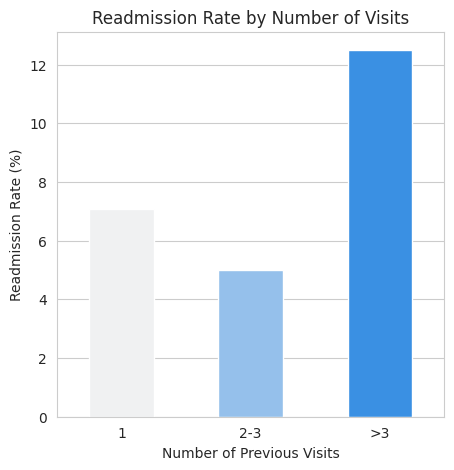

In [9]:
# Plot 1: Readmission Rate by Number of Previous Visits
visit_groups = pd.cut(patient_data['visit.times'], bins=[0, 1, 3, float('inf')], labels=['1', '2-3', '>3'])
readmission_rate_visit = patient_data.groupby(visit_groups)['re.admission.within.28.days'].mean() * 100

plt.figure(figsize=(5, 5))
sns.barplot(x=readmission_rate_visit.index, y=readmission_rate_visit.values, palette='light:dodgerblue',width=0.5)
plt.title('Readmission Rate by Number of Visits')
plt.ylabel('Readmission Rate (%)')
plt.xlabel('Number of Previous Visits')
plt.show()

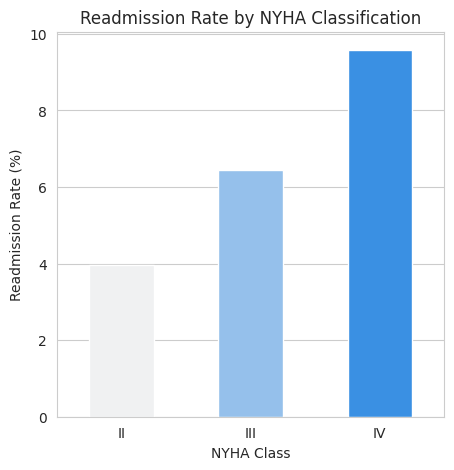

In [10]:
# Plot 2: Readmission Rate by NYHA Classification
readmission_rate_nyha = patient_data.groupby('NYHA.cardiac.function.classification')['re.admission.within.28.days'].mean() * 100

plt.figure(figsize=(5, 5))
sns.barplot(x=readmission_rate_nyha.index, y=readmission_rate_nyha.values, palette='light:dodgerblue',width=0.5)
plt.title('Readmission Rate by NYHA Classification')
plt.ylabel('Readmission Rate (%)')
plt.xlabel('NYHA Class')
plt.show()

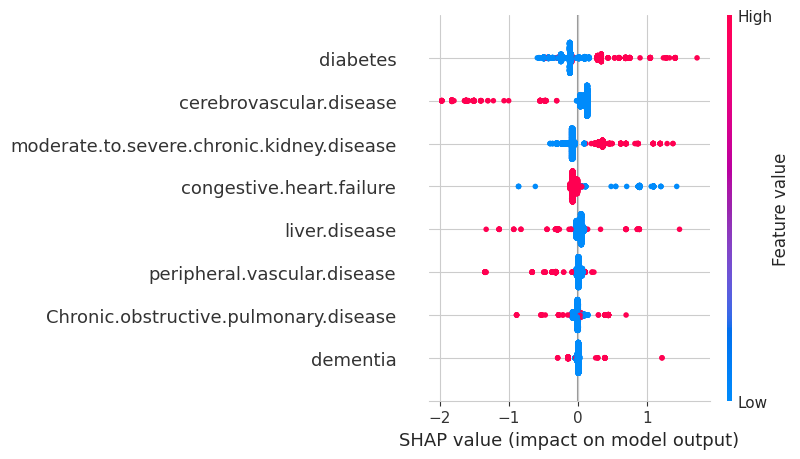

In [11]:
import xgboost as xgb
import shap

comorbidity_columns = [
    'diabetes', 'liver.disease', 'Chronic.obstructive.pulmonary.disease',
    'peripheral.vascular.disease', 'cerebrovascular.disease', 'dementia',
    'moderate.to.severe.chronic.kidney.disease', 'congestive.heart.failure'
]

# Train XGBoost model
X = patient_data[comorbidity_columns]
y = patient_data['re.admission.within.28.days']

model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X, y)

# SHAP analysis
explainer = shap.Explainer(model, X)
shap_values = explainer(X)

# Summary plot (global importance)
shap.summary_plot(shap_values, X)



#### Dot Color + Position	Meaning
* Red Dot on Right (Positive SHAP)	Condition is Present (1) → Increases Readmission Risk
* Red Dot in Center (Near 0)	Condition is Present (1) → Little to No Impact on Readmission Risk
* Red Dot on Left (Negative SHAP)	Condition is Present (1) → Reduces Readmission Risk
* Blue Dot on Right (Positive SHAP)	Condition is Absent (0) → Absence Increases Readmission Risk
* Blue Dot in Center (Near 0)	Condition is Absent (0) → Little to No Impact
* Blue Dot on Left (Negative SHAP)	Condition is Absent (0) → Absence Reduces Risk

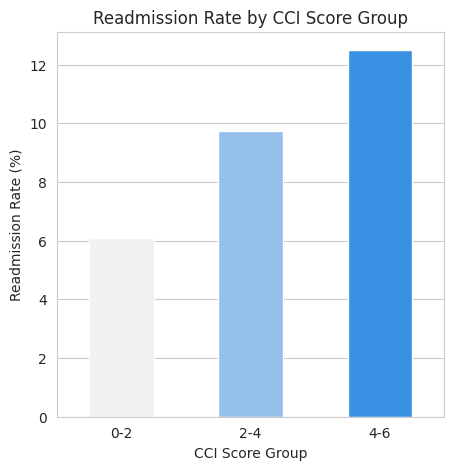

In [12]:
# Plot 4: Readmission Rate by CCI Score Group
cci_groups = pd.cut(patient_data['CCI.score'], bins=[-1, 2, 4,  float('inf')], labels=['0-2', '2-4', '4-6'])
readmission_rate_cci = patient_data.groupby(cci_groups)['re.admission.within.28.days'].mean() * 100

plt.figure(figsize=(5, 5))
sns.barplot(x=readmission_rate_cci.index, y=readmission_rate_cci.values, palette='light:dodgerblue', width=0.5)
plt.title('Readmission Rate by CCI Score Group')
plt.ylabel('Readmission Rate (%)')
plt.xlabel('CCI Score Group')
plt.show()

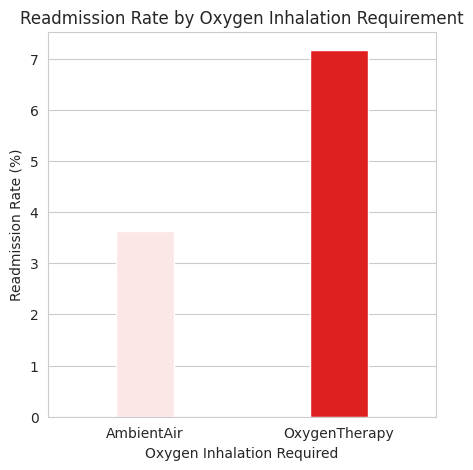

In [13]:
# Plot 5: Readmission Rate by Oxygen Inhalation Requirement
readmission_rate_oxygen = patient_data.groupby('oxygen.inhalation')['re.admission.within.28.days'].mean() * 100

plt.figure(figsize=(5, 5))
sns.barplot(x=readmission_rate_oxygen.index.astype(str), y=readmission_rate_oxygen.values, palette=['mistyrose','red'],width=0.3)
plt.title('Readmission Rate by Oxygen Inhalation Requirement')
plt.ylabel('Readmission Rate (%)')
plt.xlabel('Oxygen Inhalation Required')
plt.show()

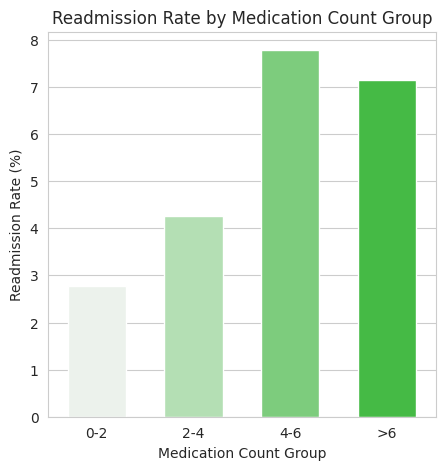

In [19]:
# Plot 6: Readmission Rate by Medication Count Group
med_count_groups = pd.cut(patient_data['med_count'], bins=[-1, 2, 4, 6, float('inf')], labels=['0-2', '2-4', '4-6', '>6'])
readmission_rate_med_count = patient_data.groupby(med_count_groups)['re.admission.within.28.days'].mean() * 100

plt.figure(figsize=(5, 5))
sns.barplot(x=readmission_rate_med_count.index, y=readmission_rate_med_count.values, palette='light:limegreen',width=0.6)
plt.title('Readmission Rate by Medication Count Group')
plt.ylabel('Readmission Rate (%)')
plt.xlabel('Medication Count Group')
plt.show()

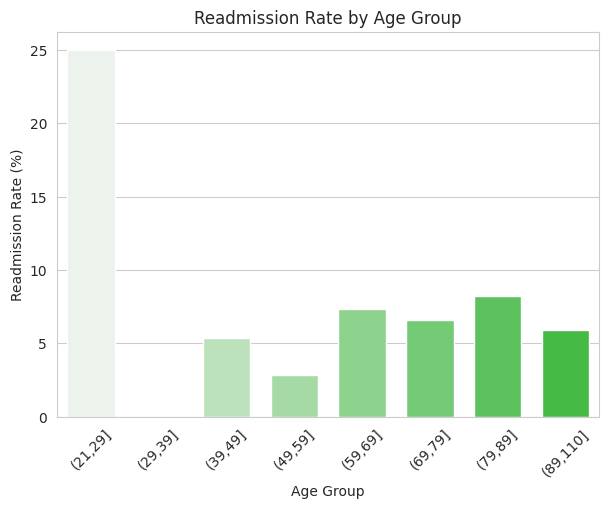

In [20]:
# Plot: Readmission Rate by Age Group

readmission_rate_age = patient_data.groupby('ageCat')['re.admission.within.28.days'].mean() * 100

plt.figure(figsize=(7, 5))
sns.barplot(x=readmission_rate_age.index, y=readmission_rate_age.values, palette='light:limegreen',width = 0.7)
plt.title('Readmission Rate by Age Group')
plt.ylabel('Readmission Rate (%)')
plt.xlabel('Age Group')
plt.xticks(rotation=45)
plt.show()


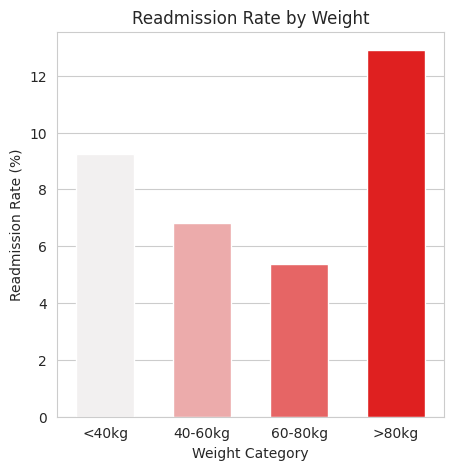

In [16]:
# Readmission Rate by Weight
weight_groups = pd.cut(patient_data['weight'], bins=[0, 40, 60, 80, float('inf')], labels=['<40kg', '40-60kg', '60-80kg', '>80kg'])
readmission_rate_weight = patient_data.groupby(weight_groups)['re.admission.within.28.days'].mean() * 100

plt.figure(figsize=(5, 5))
sns.barplot(x=readmission_rate_weight.index, y=readmission_rate_weight.values, palette='light:red',width=0.6)
plt.title('Readmission Rate by Weight')
plt.ylabel('Readmission Rate (%)')
plt.xlabel('Weight Category')
plt.show()

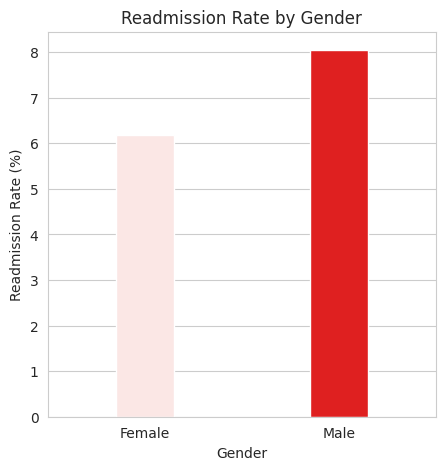

In [17]:
# Readmission Rate by Gender
readmission_rate_gender = patient_data.groupby('gender')['re.admission.within.28.days'].mean() * 100

plt.figure(figsize=(5, 5))
sns.barplot(x=readmission_rate_gender.index, y=readmission_rate_gender.values, palette=['mistyrose','red'],width=0.3)
plt.title('Readmission Rate by Gender')
plt.ylabel('Readmission Rate (%)')
plt.xlabel('Gender')
plt.show()